In [1]:
%load_ext autoreload
%autoreload 2

In [458]:
import numpy as np
import scipy.stats as st
import scipy.integrate as si
import scipy.signal as ss
import matplotlib.pyplot as plt

from causal_optoconnectics.core import (
    interventional_connection_probability, instrumental_connection_probability,
    instrumental_connection_probability_nonparametric, connection_probability_nonparametric,
    raised_cosine
)
from causal_optoconnectics.buzsaki import transfer_probability
import sys
sys.path.append('..')
from generate_triple_data import par, simulate
import networkx as nx
from nxpd import draw
from scipy.optimize import leastsq
import statsmodels.api as sm
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
import pandas as pd
%matplotlib inline

In [459]:
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize')
    )
})

## Simulate the triple setup
Neurons A,B,C have statistical dependency as given by the graph below

Stimulation S is randomly assigned, but identical for A and B

We want to determine the causal connectivity between A and C, and B and C.

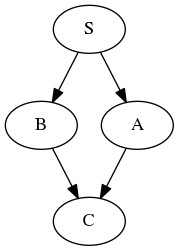

In [4]:
G = nx.DiGraph()
G.add_nodes_from(['A', 'B', 'C', 'S'])
G.add_edges_from([('A','C'), ('B', 'C'), ('S', 'A'), ('S', 'B')])
draw(G, show='ipynb')

# stim amps

In [51]:
# stim_amps = np.arange(8, 11.1, .1)
# simulations_stim_amp = defaultdict(list)
# for a in tqdm(stim_amps):
#     data = simulate(par, stop_time=1000, J_AC=2.0, J_BC=0.0, stim_amp_A=a, stim_amp_B=a)
#     stop_time = data['status']['time']
#     A_spikes, B_spikes, C_spikes = [s['times'] for s in data['spiketrains']]
    
#     simulations_stim_amp['stim_times'].append(data['epoch']['times'])
#     simulations_stim_amp['A_spikes'].append(A_spikes)
#     simulations_stim_amp['B_spikes'].append(B_spikes)
#     simulations_stim_amp['C_spikes'].append(C_spikes)
#     simulations_stim_amp['stop_time'].append(stop_time)
#     simulations_J_AC['stim_amp'].append(a)

# np.savez('simulations_stim_amp.npz', data=simulations_stim_amp)
simulations_stim_amp = np.load('simulations_stim_amp.npz', allow_pickle=True)['data'][()]

HBox(children=(IntProgress(value=0, max=31), HTML(value='')))

In [47]:
# J_ACs = np.arange(0, 5.1, .1)
# simulations_J_AC = defaultdict(list)
# for a in tqdm(J_ACs):
#     data = simulate(par, stop_time=600, J_AC=a, J_BC=0.0, stim_amp_A=6., stim_amp_B=6.)
#     stop_time = data['status']['time']
#     A_spikes, B_spikes, C_spikes = [s['times'] for s in data['spiketrains']]
    
#     simulations_J_AC['stim_times'].append(data['epoch']['times'])
#     simulations_J_AC['A_spikes'].append(A_spikes)
#     simulations_J_AC['B_spikes'].append(B_spikes)
#     simulations_J_AC['C_spikes'].append(C_spikes)
#     simulations_J_AC['stop_time'].append(stop_time)
#     simulations_J_AC['J_AC'].append(a)

# np.savez('simulations_J_AC.npz', data=simulations_J_AC)
simulations_J_AC = np.load('simulations_J_AC.npz', allow_pickle=True)['data'][()]

In [900]:
from causal_optoconnectics.core import calculate_regressors
from causal_optoconnectics.tools import histogram
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from linearmodels.iv import IV2SLS

# def causal_connectivity(
#     x, y, stim_times, x_mu, x_sigma, y_mu, y_sigma, cutoff):
    
#     Z, X, Y, stim_times = calculate_regressors(x, y, stim_times)
#     Z = abs(Z)
#     Z = (Z < cutoff).astype(int)
#     X = ((X > x_mu - x_sigma) & (X < x_mu + x_sigma)).astype(int)
#     Y = ((Y > y_mu - y_sigma) & (Y < y_mu + y_sigma)).astype(int)
    
#     Z = np.vstack((Z, np.ones(Z.shape[0]))).T
#     X = np.vstack((X, np.ones(X.shape[0]))).T

#     model = IV2SLS(dependent=Y, exog=None, endog=X, instruments=Z)
#     try:
#         res = model.fit(cov_type='unadjusted')
#         beta = res.params[0]
#     except:
#         beta = np.nan
#     return beta


# def causal_connectivity(
#     x, y, stim_times, x_mu, x_sigma, y_mu, y_sigma, 
#     n_bases, bin_size, offset):
#     Z, X, Y, stim_times = calculate_regressors(x, y, stim_times)

# #     X = ((X > x_mu - x_sigma) & (X < x_mu + x_sigma)).astype(int)
#     Y = ((Y > y_mu - y_sigma) & (Y < y_mu + y_sigma)).astype(int)

#     Z = abs(Z)
# #     Z = (Z < cutoff).astype(int)
# #     Z = np.vstack((Z, np.ones(Z.shape[0]))).T
    
#     cutoff = Z.max()

#     time, bases, centers = raised_cosine(
#         n_bases, bin_size, np.array([0, cutoff]), offset)

#     def index(t, bin_size):
#         return np.minimum(np.ceil(t / bin_size).astype(int), len(time)-1)
    
#     idxs = index(Z, bin_size)
#     Z = bases[idxs,:]
# #     Z = Z.reshape(-1, 1)
# #     Z = sm.add_constant(Z)
    
#     model = sm.OLS(endog=X, exog=Z)
#     res = model.fit()
    
#     X_hat = np.vstack([X, res.resid]).T
    
#     model = LogisticRegression(C=1e5, solver='liblinear')
#     model.fit(X_hat, Y)
#     #
# #     beta = model.predict_proba([[1], [0]])[:,0]
#     delta_1, (alpha_1, theta_1) = model.intercept_, model.coef_[0]
#     logit = lambda x: 1 / (1 + np.exp(-x))
#     delta, alpha = np.array([delta_1, alpha_1]) / np.sqrt(1 + theta_1**2 * np.var(res.resid))
# #     beta = logit(delta + alpha) - logit(delta)
# #     t = np.arange(0,.1,.001)
# #     plt.plot(t,logit(delta + alpha*t))
# #     return beta
#     return logit(delta + alpha*x_mu) - logit(delta + alpha*y_mu)

# def causal_connectivity(
#     x, y, stim_times, x_mu, x_sigma, y_mu, y_sigma, 
#     n_bases, bin_size, offset):
#     Z, X, Y, stim_times = calculate_regressors(x, y, stim_times)
# #     X = ((X > x_mu - x_sigma) & (X < x_mu + x_sigma)).astype(int)
#     Y = ((Y > y_mu - y_sigma) & (Y < y_mu + y_sigma)).astype(int)

#     Z = abs(Z)
    
#     cutoff = Z.max()

#     time, bases, centers = raised_cosine(
#         n_bases, bin_size, np.array([0, cutoff]), offset)

#     def index(t, bin_size):
#         return np.minimum(np.ceil(t / bin_size).astype(int), len(time)-1)
    
#     idxs = index(Z, bin_size)
#     Z = bases[idxs,:]
    
#     X = sm.add_constant(X)
    
#     model = IV2SLS(dependent=Y, exog=None, endog=X, instruments=Z)
# #     try:
#     res = model.fit(cov_type='unadjusted')
#     beta = res.params[0]
# #     except:
# #         beta = np.nan
# #     return beta


def causal_connectivity(
    x, y, stim_times, x_mu, x_sigma, y_mu, y_sigma, 
    n_bases, bin_size, offset):

#     Y = ((Y > y_mu - y_sigma) & (Y < y_mu + y_sigma)).astype(int)
#     bins = [y_mu - y_sigma, y_mu + y_sigma]
#     Y_ = np.array([
#         np.histogram(y - s, bins=bins)[0] for s in stim_times])

    stim_times = stim_times.astype(float)

    src_x = np.searchsorted(x, stim_times, side='right')
    remove_idxs, = np.where((src_x==len(x)) | (src_x==0))
    src_x = np.delete(src_x, remove_idxs)
    stim_times = np.delete(stim_times, remove_idxs)
    Z = x[src_x-1] - stim_times
    X = x[src_x] - stim_times

    stim_win = np.insert(
        stim_times + y_mu - y_sigma,
        np.arange(len(stim_times)) + 1,
        stim_times + y_mu + y_sigma)
    src_y = np.searchsorted(y, stim_win, side='left')
    cnt_y = np.diff(src_y.reshape((int(len(src_y) / 2), 2)))
    Y = cnt_y.flatten()
    
#     assert np.array_equal(Y, Y_.flatten()), [i for i in range(len(Y)) if Y[i] != Y_[i]]
    Z = abs(Z)
    
    cutoff = Z.max()

    time, bases, centers = raised_cosine(
        n_bases, bin_size, np.array([0, cutoff]), offset)

    def index(t, bin_size):
        return np.minimum(np.ceil(t / bin_size).astype(int), len(time)-1)
    
    idxs = index(Z, bin_size)
    Z = bases[idxs,:]
#     Z = sm.add_constant(Z)
    
    model1 = sm.OLS(endog=X, exog=Z)
    res1 = model1.fit()
    
    X_hat = sm.add_constant(res1.fittedvalues)
#     X_hat = np.vstack([X, res1.resid]).T
#     X_hat = sm.add_constant(X_hat)
    model2 = sm.OLS(endog=Y, exog=X_hat)
    res2 = model2.fit()
    
#     beta = sum(res2.params[1])
    beta = res2.params[1]

    return beta

In [904]:
iv_params = {
    'x_mu': 2e-3,
    'x_sigma': 1e-3,
    'y_mu': 5e-3,
    'y_sigma': 5e-3,
    'n_bases': 200,
    'bin_size': 1e-5,
    'offset': 1e-10
}

beta_AC = causal_connectivity(
    A_spikes, C_spikes, stim_times,  **iv_params)

beta_BC = causal_connectivity(
    B_spikes, C_spikes, stim_times,  **iv_params)

beta_AC, beta_BC

(-13.737444834358984, -0.7205682067313348)

In [831]:
float(beta_AC[0])

0.3608150546833864

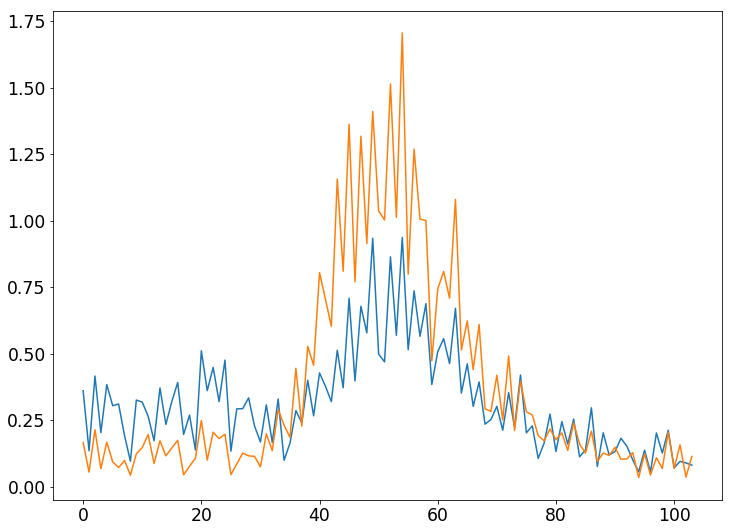

In [832]:
# plt.plot(beta_AC[0])
plt.plot(beta_AC)

# plt.plot(beta_BC[0])
plt.plot(beta_BC)

In [769]:
i = 0

iv_params = {
    'x_mu': 2e-3,
    'x_sigma': 1e-3,
    'y_mu': 7.5e-3,
    'y_sigma': 2.2e-3,
    'n_bases': 20,
    'bin_size': 1e-4,
    'offset': 1e-3,
#     'cutoff': 4e-3
}

simulations = simulations_J_AC
amps = simulations_J_AC['J_AC']

# simulations = simulations_stim_amp
# amps = simulations_stim_amp['stim_amps']

stim_times = simulations['stim_times'][i] / 1000
A_spikes = simulations['A_spikes'][i] / 1000
B_spikes = simulations['B_spikes'][i] / 1000
C_spikes = simulations['C_spikes'][i] / 1000
stop_time = simulations['stop_time'][i] / 1000

beta_AC = causal_connectivity(
    A_spikes, C_spikes, stim_times,  **iv_params)

beta_AC

-0.01063636332419524

In [770]:
simulations = simulations_J_AC
amps = simulations_J_AC['J_AC']

# simulations = simulations_stim_amp
# amps = simulations_stim_amp['stim_amps']

# causal_connectivity = interventional_connection_probability
# causal_connectivity = instrumental_connection_probability
# causal_connectivity = instrumental_connection_probability_nonparametric

iv_params = {
    'x_mu': 2e-3,
    'x_sigma': 1e-3,
    'y_mu': 7.5e-3,
    'y_sigma': 2.2e-3,
    'n_bases': 20,
    'bin_size': 1e-4,
    'offset': 1e-3
}

trans_prob_params = {
    'y_mu': 4e-3,
    'y_sigma': 1e-3,
    'bin_size': 1e-3,
    'limit': 15e-3,
    'hollow_fraction': .6,
    'width': 60
}

time_shift = 15e-3

results = defaultdict(list)
for i, a in enumerate(tqdm(amps)):

    stim_times = simulations['stim_times'][i] / 1000
    A_spikes = simulations['A_spikes'][i] / 1000
    B_spikes = simulations['B_spikes'][i] / 1000
    C_spikes = simulations['C_spikes'][i] / 1000
    stop_time = simulations['stop_time'][i] / 1000
    
    beta_AC = causal_connectivity(A_spikes, C_spikes, stim_times, **iv_params)
    beta_BC = causal_connectivity(B_spikes, C_spikes, stim_times, **iv_params)
    
    beta_ACr = causal_connectivity(A_spikes, C_spikes, stim_times - time_shift, **iv_params)
    beta_BCr = causal_connectivity(B_spikes, C_spikes, stim_times - time_shift, **iv_params)

    tr_AC = transfer_probability(A_spikes, C_spikes, **trans_prob_params)[0]
    tr_BC = transfer_probability(B_spikes, C_spikes, **trans_prob_params)[0]
    
    
    results['beta_AC'].append(beta_AC)
    results['beta_BC'].append(beta_BC)
    results['tr_AC'].append(tr_AC)
    results['tr_BC'].append(tr_BC)  
    results['beta_AC_shift'].append(beta_ACr)    
    results['beta_BC_shift'].append(beta_BCr)
    results['rate_A'].append(len(A_spikes) / stop_time)
    results['rate_B'].append(len(B_spikes) / stop_time)
    results['rate_C'].append(len(C_spikes) / stop_time)
    results['rate_S'].append(len(stim_times) / stop_time)
#     break
    
results = pd.DataFrame(results)

HBox(children=(IntProgress(value=0, max=51), HTML(value='')))

Text(0.5,1,'BC')

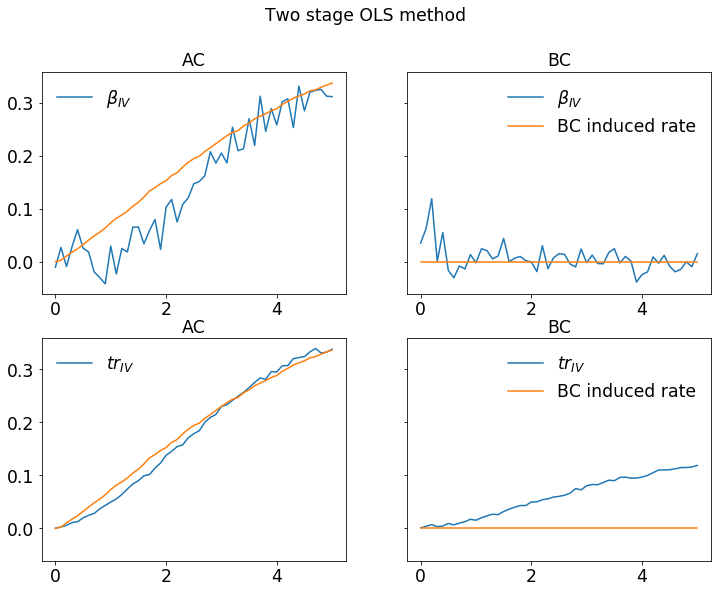

In [771]:
fig, axs = plt.subplots(2,2, sharey=True)
axba, axbb, axta, axtb = axs.flatten()
s = 1

plt.suptitle('Two stage OLS method', fontsize='xx-large')

axba.plot(amps, s * results['beta_AC'], label=r'$\beta_{IV}$')
# axba.plot(amps, s * results['beta_AC_shift'], label=r'$\beta_{IV}$ shifted')
axba.plot(amps, (results['rate_C'] - results['rate_C'][0]) / (results['rate_A'] + results['rate_S']))
axba.legend(frameon=False, loc=0)
# axba.set_xlabel('Connection strength AC')
axba.set_title('AC')

axbb.plot(amps, s * results['beta_BC'], label=r'$\beta_{IV}$')
# axbb.plot(amps, s * results['beta_BC_shift'], label=r'$\beta_{IV}$ shifted')
axbb.plot(amps, np.zeros_like(amps), label='BC induced rate')
axbb.legend(frameon=False, loc=0)
# axbb.set_xlabel('Connection strength AC')
axbb.set_title('BC')

axta.plot(amps, s * results['tr_AC'], label=r'$tr_{IV}$')
axta.plot(amps, (results['rate_C'] - results['rate_C'][0]) / (results['rate_A'] + results['rate_S']))
axta.legend(frameon=False, loc=0)
axta.set_title('AC')

axtb.plot(amps, s * results['tr_BC'], label=r'$tr_{IV}$')
axtb.plot(amps, np.zeros_like(amps), label='BC induced rate')
axtb.legend(frameon=False, loc=0)
axtb.set_title('BC')

In [226]:
i = -1

iv_params = {
#     'x_mu': 2e-3,
#     'x_sigma': 1e-3,
#     'y_mu': 7.5e-3,
#     'y_sigma': 2.2e-3,
#     'n_bases': 20,
    'bin_size': 1e-4,
#     'offset': 1e-3,
    'cutoff': [50e-3, 3.5]
}

simulations = simulations_J_AC
amps = simulations_J_AC['J_AC']

# simulations = simulations_stim_amp
# amps = simulations_stim_amp['stim_amps']

stim_times = simulations['stim_times'][i] / 1000
A_spikes = simulations['A_spikes'][i] / 1000
B_spikes = simulations['B_spikes'][i] / 1000
C_spikes = simulations['C_spikes'][i] / 1000
stop_time = simulations['stop_time'][i] / 1000

beta_AC = instrumental_connection_probability_nonparametric(
    A_spikes, C_spikes, stim_times,  plot=False, **iv_params)

beta_BC = instrumental_connection_probability_nonparametric(
    B_spikes, C_spikes, stim_times, plot=False, **iv_params)

# print(max(beta_AC), max(beta_BC))

# trans_prob_params = {
#     'y_mu': 4e-3,
#     'y_sigma': 1e-3,
#     'bin_size': 1e-3,
#     'limit': 15e-3,
#     'hollow_fraction': .6,
#     'width': 60
# }

# tr_AC = transfer_probability(A_spikes, C_spikes, **trans_prob_params)[0]
# tr_BC = transfer_probability(B_spikes, C_spikes, **trans_prob_params)[0]


beta_AC, beta_BC#, tr_AC, tr_BC

(13.858037386589007, 0.35964455160346137)

In [178]:
res = defaultdict(list)
for cutoff in tqdm(np.arange(1e-3, 52e-3, 2e-3)):
    iv_params = {
    #     'x_mu': 2e-3,
    #     'x_sigma': 1e-3,
    #     'y_mu': 7.5e-3,
    #     'y_sigma': 2.2e-3,
    #     'n_bases': 20,
        'bin_size': 1e-3,
    #     'offset': 1e-3,
        'cutoff': cutoff
    }

    simulations = simulations_J_AC
    amps = simulations_J_AC['J_AC']

    # simulations = simulations_stim_amp
    # amps = simulations_stim_amp['stim_amps']

    stim_times = simulations['stim_times'][i] / 1000
    A_spikes = simulations['A_spikes'][i] / 1000
    B_spikes = simulations['B_spikes'][i] / 1000
    C_spikes = simulations['C_spikes'][i] / 1000
    stop_time = simulations['stop_time'][i] / 1000

    beta_AC = instrumental_connection_probability_nonparametric(
        A_spikes, C_spikes, stim_times,  plot=False, **iv_params)

    beta_BC = instrumental_connection_probability_nonparametric(
        B_spikes, C_spikes, stim_times, plot=False, **iv_params)
    res['beta_BC'].append(beta_BC)
    res['beta_AC'].append(beta_AC)    
    res['cutoff'].append(cutoff)    

HBox(children=(IntProgress(value=0, max=26), HTML(value='')))

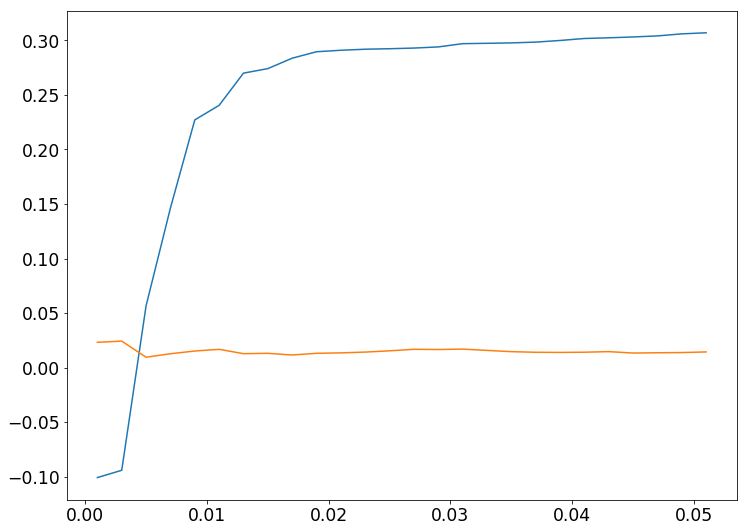

In [179]:
plt.plot(res['cutoff'], res['beta_AC'])
plt.plot(res['cutoff'], res['beta_BC'])

# error(t)

In [907]:
# data = simulate(par, stop_time=2000, J_AC=2.0, J_BC=0.0, stim_amp_A=6., stim_amp_B=6.)
data = np.load('../results/triple_4000.npz', allow_pickle=True)['data'][()]

stop_time = data['status']['time'] / 1000
stim_times = data['epoch']['times'] / 1000
A_spikes, B_spikes, C_spikes = [s['times'] / 1000 for s in data['spiketrains']]

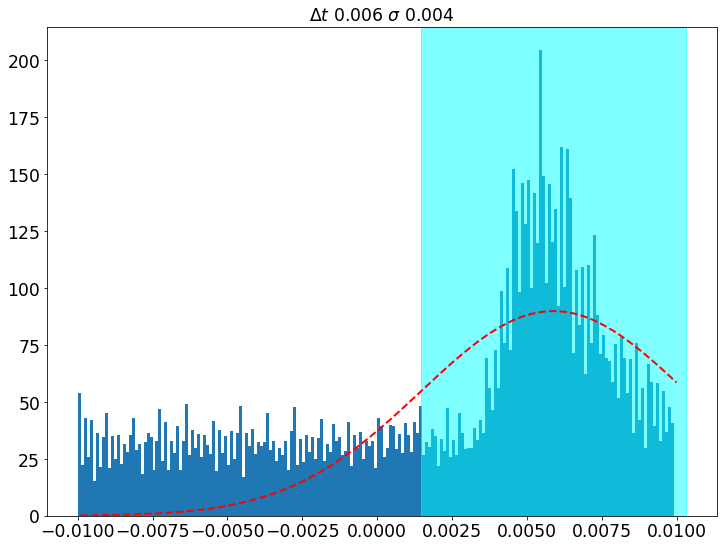

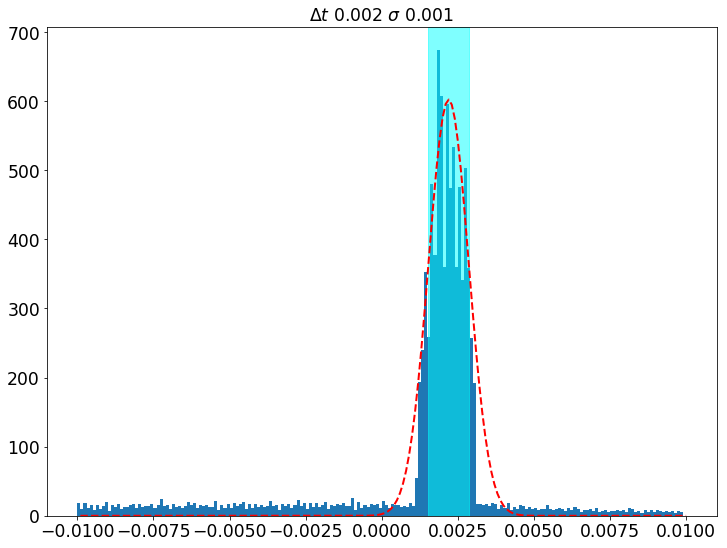

In [699]:
from causal_optoconnectics.cch import fit_latency
delta_t_C, sigma_C = fit_latency(stim_times, C_spikes, limit=10e-3, plot=True)
plt.figure()
delta_t_A, sigma_A = fit_latency(stim_times, A_spikes, limit=10e-3, plot=True)

In [709]:
iv_params_1 = {
    'x_mu': 2e-3,
    'x_sigma': 1.5e-3,
    'y_mu': 7.5e-3,
    'y_sigma': 2.2e-3,
    'n_bases': 20,
    'bin_size': 1e-4,
    'offset': 1e-4,
#     'cutoff': 10e-3
}

iv_params_2 = {
    'x_mu': 2e-3,
    'x_sigma': 1.5e-3,
    'y_mu': 7.5e-3,
    'y_sigma': 2.2e-3,
}


def causal_connectivity_1(
    x, y, stim_times, x_mu, x_sigma, y_mu, y_sigma, 
    n_bases=20, bin_size=1e-3, offset=1e-2, cutoff=None):
    
    Z, X, Y, stim_times = calculate_regressors(x, y, stim_times)
    Z = abs(Z)
#     Z = (Z < cutoff).astype(int)
#     Z = np.vstack((Z, np.ones(Z.shape[0]))).T
    
    if cutoff is None:
        cutoff = Z.max()

    time, bases, centers = raised_cosine(
        n_bases, bin_size, np.array([0, cutoff]), offset)

    def index(t, bin_size):
        return np.minimum(np.ceil(t / bin_size).astype(int), len(time)-1)
    
    idxs = index(Z, bin_size)
    Z = bases[idxs,:]
    
    X = ((X > x_mu - x_sigma) & (X < x_mu + x_sigma)).astype(int)
    Y = ((Y > y_mu - y_sigma) & (Y < y_mu + y_sigma)).astype(int)
    
    
    X = np.vstack((X, np.ones(X.shape[0]))).T

    model = IV2SLS(dependent=Y, exog=None, endog=X, instruments=Z)
    try:
        res = model.fit(cov_type='unadjusted')
        beta = res.params[0]
    except:
        beta = np.nan
    return beta


def causal_connectivity_2( # matches logistic exactly
    x, y, stim_times, x_mu, x_sigma, y_mu, y_sigma):
    
    _, X, Y, stim_times = calculate_regressors(x, y, stim_times)

    X = ((X > x_mu - x_sigma) & (X < x_mu + x_sigma)).astype(int)
    Y = ((Y > y_mu - y_sigma) & (Y < y_mu + y_sigma)).astype(int)
    
    X = np.vstack((X, np.ones(X.shape[0]))).T

    model = IV2SLS(dependent=Y, exog=X, endog=None, instruments=None)
    try:
        res = model.fit(cov_type='unadjusted')
        beta = res.params[0]
    except:
        beta = np.nan
    return beta


def causal_connectivity_3(
    x, y, stim_times, x_mu, x_sigma, y_mu, y_sigma, 
    n_bases, bin_size, offset):
    Z, X, Y, stim_times = calculate_regressors(x, y, stim_times)

#     X = ((X > x_mu - x_sigma) & (X < x_mu + x_sigma)).astype(int)
    Y = ((Y > y_mu - y_sigma) & (Y < y_mu + y_sigma)).astype(int)

    Z = abs(Z)
    
    cutoff = Z.max()

    time, bases, centers = raised_cosine(
        n_bases, bin_size, np.array([0, cutoff]), offset)

    def index(t, bin_size):
        return np.minimum(np.ceil(t / bin_size).astype(int), len(time)-1)
    
    idxs = index(Z, bin_size)
    Z = bases[idxs,:]
    
    model = sm.OLS(endog=X, exog=Z)
    res = model.fit()
    
    X_hat = np.vstack([X, res.resid]).T
    
    model = LogisticRegression(C=1e5, solver='liblinear')
    model.fit(X_hat, Y)

    delta_1, (alpha_1, theta_1) = model.intercept_, model.coef_[0]
    logit = lambda x: 1 / (1 + np.exp(-x))
    delta, alpha = np.array([delta_1, alpha_1]) / np.sqrt(1 + theta_1**2 * np.var(res.resid))
#     beta = logit(delta + alpha) - logit(delta)

    return logit(delta + alpha * x_mu) - logit(delta + alpha * x_mu * 10)


# def causal_connectivity_3(
#     x, y, stim_times, x_mu, x_sigma, y_mu, y_sigma, 
#     n_bases=20, bin_size=1e-3, offset=1e-2, cutoff=None):
#     Z, X, Y, stim_times = calculate_regressors(x, y, stim_times)

#     X = ((X > x_mu - x_sigma) & (X < x_mu + x_sigma)).astype(int)
#     Y = ((Y > y_mu - y_sigma) & (Y < y_mu + y_sigma)).astype(int)

#     Z = abs(Z)
# #     Z = (Z < cutoff).astype(int)
# #     Z = np.vstack((Z, np.ones(Z.shape[0]))).T
    
#     if cutoff is None:
#         cutoff = Z.max()

#     time, bases, centers = raised_cosine(
#         n_bases, bin_size, np.array([0, cutoff]), offset)

#     def index(t, bin_size):
#         return np.minimum(np.ceil(t / bin_size).astype(int), len(time)-1)
    
#     idxs = index(Z, bin_size)
#     Z = bases[idxs,:]
# #     Z = Z.reshape(-1, 1)
    
#     model1 = LogisticRegression(C=1e5, solver='liblinear')#, penalty='none')
#     model1.fit(Z, X)

#     # X_hat = model1.predict_proba(Z_bases)[:,1]
#     X_hat = model1.predict(Z)

#     model = LogisticRegression(C=1e5, solver='liblinear')#, penalty='none')
#     model.fit(X_hat.reshape(-1, 1), Y)
#     #
#     beta = model.predict_proba([[1], [0]])[:,0]

#     return float(np.diff(beta))

In [710]:
time_shift = 15e-3

results_t = defaultdict(list)
times = np.arange(100, stop_time, 100)

for t in tqdm(times):
    mask_A = (A_spikes < t)
    mask_B = (B_spikes < t)
    mask_C = (C_spikes < t)
    mask_S = (stim_times < t)
    
    beta_AC_1 = causal_connectivity_1(
        A_spikes[mask_A], C_spikes[mask_C], stim_times[mask_S], **iv_params_1)
    beta_BC_1 = causal_connectivity_1(
        B_spikes[mask_B], C_spikes[mask_C], stim_times[mask_S], **iv_params_1)
    
    results_t['beta_AC_1'].append(beta_AC_1)
    results_t['beta_BC_1'].append(beta_BC_1) 
    
    beta_AC_2 = causal_connectivity_2(
        A_spikes[mask_A], C_spikes[mask_C], stim_times[mask_S], **iv_params_2)
    beta_BC_2 = causal_connectivity_2(
        B_spikes[mask_B], C_spikes[mask_C], stim_times[mask_S], **iv_params_2)
   
    results_t['beta_AC_2'].append(beta_AC_2)    
    results_t['beta_BC_2'].append(beta_BC_2)
    
    beta_AC_3 = causal_connectivity_3(
        A_spikes[mask_A], C_spikes[mask_C], stim_times[mask_S], **iv_params_1)
    beta_BC_3 = causal_connectivity_3(
        B_spikes[mask_B], C_spikes[mask_C], stim_times[mask_S], **iv_params_1)
   
    results_t['beta_AC_3'].append(beta_AC_3)    
    results_t['beta_BC_3'].append(beta_BC_3)
    
    results_t['rate_A'].append(sum(mask_A) / t)
    results_t['rate_B'].append(sum(mask_B) / t)
    results_t['rate_C'].append(sum(mask_C) / t)
    results_t['rate_S'].append(sum(mask_S) / t)
    
results_t = {k: np.array(v) for k, v in results_t.items()}

HBox(children=(IntProgress(value=0, max=40), HTML(value='')))

In [492]:
simulations_J_AC.keys()

dict_keys(['B_spikes', 'stim_amp', 'A_spikes', 'J_AC', 'stop_time', 'C_spikes', 'stim_times'])

In [674]:
baseline_C = len(simulations_J_AC['C_spikes'][0]) / simulations_J_AC['stop_time'][0] * 1000
baseline_C

15.441707844554251

Text(0.5,1,'BC')

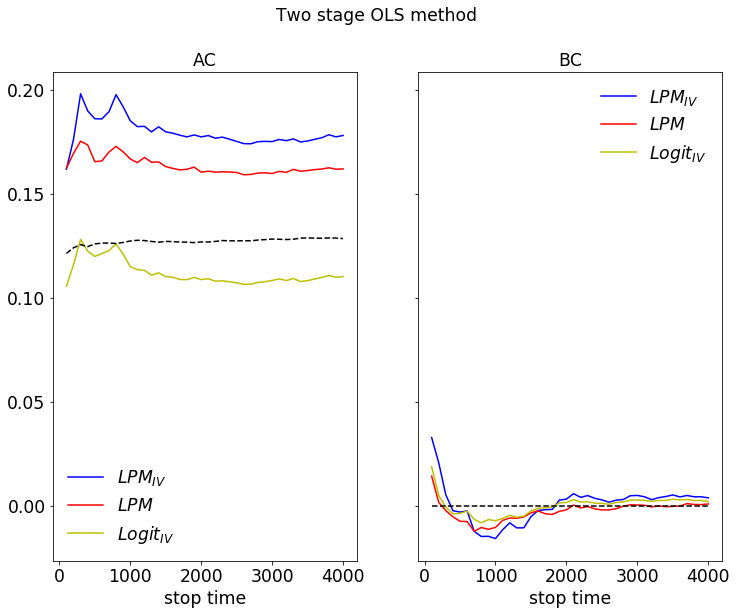

In [711]:
fig, (axa, axb) = plt.subplots(1,2, sharey=True)

s = 1

plt.suptitle('Two stage OLS method', fontsize='xx-large')

axa.plot(times, s * results_t['beta_AC_1'], 'b', label=r'$LPM_{IV}$')

axb.plot(times, s * results_t['beta_BC_1'], 'b', label=r'$LPM_{IV}$')

axa.plot(times, s * results_t['beta_AC_2'], 'r', label=r'$LPM$')

axb.plot(times, s * results_t['beta_BC_2'], 'r', label=r'$LPM$')

axa.plot(times, s * results_t['beta_AC_3'], 'y', label=r'$Logit_{IV}$')

axb.plot(times, s * results_t['beta_BC_3'], 'y', label=r'$Logit_{IV}$')


axa.plot(times, (results_t['rate_C'] - baseline_C) / (results_t['rate_A'] + results_t['rate_S']), '--k')
axb.plot(times, np.zeros_like(times), '--k')


axa.legend(frameon=False, loc=0)
axa.set_xlabel('stop time')
axa.set_title('AC')

axb.legend(frameon=False, loc=0)
axb.set_xlabel('stop time')
axb.set_title('BC')

In [908]:
def causal_connectivity(
    x, y, stim_times, y_mu, y_sigma, 
    n_bases, bin_size, offset):
    stim_times = stim_times.astype(float)

    src_x = np.searchsorted(x, stim_times, side='right')
    remove_idxs, = np.where((src_x==len(x)) | (src_x==0))
    src_x = np.delete(src_x, remove_idxs)
    stim_times = np.delete(stim_times, remove_idxs)
    Z = x[src_x-1] - stim_times
    X = x[src_x] - stim_times

    stim_win = np.insert(
        stim_times + y_mu - y_sigma,
        np.arange(len(stim_times)) + 1,
        stim_times + y_mu + y_sigma)
    src_y = np.searchsorted(y, stim_win, side='left')
    cnt_y = np.diff(src_y.reshape((int(len(src_y) / 2), 2)))
    Y = cnt_y.flatten()
    
    Z = abs(Z)
    
    cutoff = Z.max()

    time, bases, centers = raised_cosine(
        n_bases, bin_size, np.array([0, cutoff]), offset)

    def index(t, bin_size):
        return np.minimum(np.ceil(t / bin_size).astype(int), len(time)-1)
    
    idxs = index(Z, bin_size)
    Z = bases[idxs,:]
    
    model1 = sm.OLS(endog=X, exog=Z)
    res1 = model1.fit()
    
    X_hat = sm.add_constant(res1.fittedvalues)
    model2 = sm.OLS(endog=Y, exog=X_hat)
    res2 = model2.fit()
    
    beta = res2.params[1]

    return beta

In [910]:
time_shift = 15e-3

results_t = defaultdict(list)
times = np.arange(100, stop_time, 100)

iv_params = {
    'y_mu': 5e-3,
    'y_sigma': 5e-3,
    'n_bases': 20,
    'bin_size': 1e-4,
    'offset': 1e-4
}

for t in tqdm(times):
    mask_A = (A_spikes < t)
    mask_B = (B_spikes < t)
    mask_C = (C_spikes < t)
    mask_S = (stim_times < t)
    
    beta_AC = causal_connectivity(
        A_spikes[mask_A], C_spikes[mask_C], stim_times[mask_S], **iv_params)
    beta_BC = causal_connectivity(
        B_spikes[mask_B], C_spikes[mask_C], stim_times[mask_S], **iv_params)
    
    results_t['beta_AC'].append(beta_AC)
    results_t['beta_BC'].append(beta_BC) 
    
    
    results_t['rate_A'].append(sum(mask_A) / t)
    results_t['rate_B'].append(sum(mask_B) / t)
    results_t['rate_C'].append(sum(mask_C) / t)
    results_t['rate_S'].append(sum(mask_S) / t)
    
results_t = {k: np.array(v) for k, v in results_t.items()}

HBox(children=(IntProgress(value=0, max=40), HTML(value='')))

Text(0.5,1,'BC')

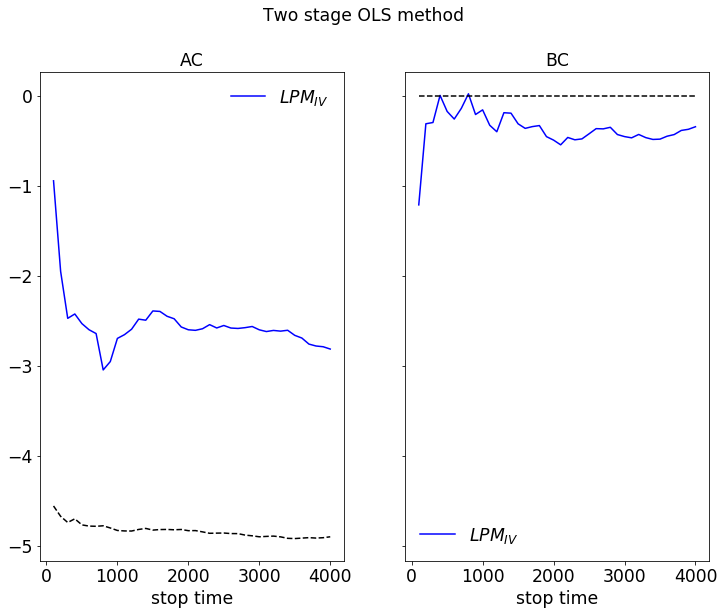

In [912]:
fig, (axa, axb) = plt.subplots(1,2, sharey=True)

s = 1

plt.suptitle('Two stage OLS method', fontsize='xx-large')

axa.plot(times, s * results_t['beta_AC'], 'b', label=r'$LPM_{IV}$')

axb.plot(times, s * results_t['beta_BC'], 'b', label=r'$LPM_{IV}$')


axa.plot(times, baseline_C - results_t['rate_C'], '--k')
axb.plot(times, np.zeros_like(times), '--k')


axa.legend(frameon=False, loc=0)
axa.set_xlabel('stop time')
axa.set_title('AC')

axb.legend(frameon=False, loc=0)
axb.set_xlabel('stop time')
axb.set_title('BC')